In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fractions import Fraction
import scipy.stats as st
from sklearn.utils import resample
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import matplotlib
import pickle
import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# 1. Load the data

In [2]:
hair_cortisol_data_path = '../data/hair cortisol - 140120.xlsx'
data_to_analyze = pd.read_excel(hair_cortisol_data_path, sheet_name='proccessed', index_col=0, nrows=8)
data_to_analyze = data_to_analyze.T.reset_index()
data_to_analyze.rename(columns={'index': 'sample ID'}, inplace=True)
data_to_analyze = pd.melt(data_to_analyze, id_vars=['sample ID', 'subject ID', 'type'], var_name='segment')
data_to_analyze['value'] = pd.to_numeric(data_to_analyze['value'])
data_to_analyze['segment'] = pd.to_numeric(data_to_analyze['segment'])
data_to_analyze['sample ID'] = data_to_analyze['sample ID'].astype(str)
data_to_analyze

,sample ID,subject ID,type,segment,value
0,10,10,o,0,75.301219
1,11,11,o,0,30.450298
2,15,15,o,0,17.078175
3,20,20,o,0,12.960955
4,21,21,o,0,12.725356
...,...,...,...,...,...
433,S66d,66,rw,5,5.991447
434,S67d,67,rw,5,4.126335
435,81,81,o,5,0.635124
436,82,82,o,5,6.944967


# 2. Clean the data

In [3]:
def hair_data_to_numpy(data_df):
    '''
    organizes the dataframe in a matrix form of [#subjects X #time]
    '''
    
    orig_and_repeats_to_mat = data_df.pivot_table(
        values='value',
        index=['subject ID', 'type'],
        columns='segment'
    ).reset_index()
    raw_data_mat = orig_and_repeats_to_mat[np.arange(6)].to_numpy().T
    
    return raw_data_mat, orig_and_repeats_to_mat

In [4]:
low_clean = data_to_analyze.copy()
low_clean.loc[low_clean['value'] == 0, 'value'] = np.NaN
low_clean.drop(index=low_clean.loc[low_clean['type'].str.contains('r')].index, inplace=True)

low_mat, low_df = hair_data_to_numpy(low_clean)

In [5]:
low_mat.shape

(6, 59)

In [6]:
valid_subjects_idx = np.all(np.isfinite(low_mat), axis=0)
low_mat = low_mat[:, valid_subjects_idx]

In [7]:
low_df['subject ID'][valid_subjects_idx].values

array([10, 11, 15, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 57,
       58, 59, 60, 62, 63, 64, 66, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78,
       79, 81, 82, 86], dtype=int64)

In [8]:
low_mat.shape

(6, 55)

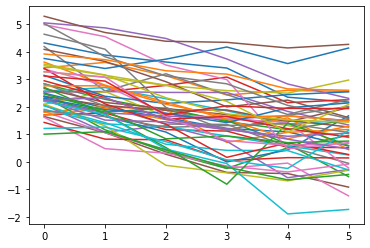

In [9]:
_ = plt.plot(np.log(low_mat))

# 3. Analyze

In [10]:
def rank_regression(x, y):
    
    n = len(x)
    ranked_x = st.rankdata(x)
    ranked_y = st.rankdata(y)
    
    a = n*((n+1)**2)/4
    beta = (np.sum(ranked_x*ranked_y) - a) / (np.sum(ranked_x**2) - a)
    alpha = (1-beta)*(n+1)/2
    
    return alpha, beta


def normalize_by_fitting(data, t, sigma=None, bounds=(-np.inf, np.inf), plot=False, exp=True):
    '''
    normalizes the data by canceling the exponential component of it
    
    @params:
        data - [#time X #samples]
        sigma - [#time X #samples], should contain values of standard deviations of errors in data.
                In this case, the optimized function is ``chisq = sum((r / sigma) ** 2)``
        bounds - 2-tuple of array_like, optional
                 Lower and upper bounds on parameters. Defaults to no bounds.
                 Each element of the tuple must be either an array with the length equal
                 to the number of parameters, or a scalar (in which case the bound is
                 taken to be the same for all parameters.) Use ``np.inf`` with an
                 appropriate sign to disable bounds on all or some parameters.
        
    @return:
        normalized data - data.shape
        fitted params - [#samples X #params]
        params_std
    '''
    
    _sigma = sigma
    linear = lambda t, A, alpha: np.log(A) - alpha*t

    fitted_params = np.zeros((data.shape[1], 2))
    params_std = np.zeros_like(fitted_params)
    data_normalized = np.zeros_like(data)
    for i in range(data.shape[1]):
        y = np.log(data[:, i])
        if sigma is not None:
            _sigma = sigma[:, i]
        popt, pcov = curve_fit(linear, t, y, sigma=_sigma, bounds=bounds)
        data_normalized[:, i] = np.log(data[:, i]) - np.log(popt[0]) + popt[1]*t
        if exp:
            data_normalized[:, i] = np.exp(data_normalized[:, i])
        fitted_params[i] = popt
        params_std[i] = np.sqrt(np.diag(pcov))
            
    if plot:
        plt.figure(figsize=(4*2,3*2))
        plt.plot(np.arange(1, 7), data_normalized)
        plt.xlabel('hair segment', size=14)
        plt.ylabel('normalized cortisol', size=14)
        plt.show()
        
        f, axs = plt.subplots(2, 3, figsize=(4*3, 3*2), sharex=True)
        axs_f = axs.flatten()
        for i, ax in enumerate(axs_f):
            sns.distplot(data_normalized[i], ax=ax)
        plt.show()
        
        N_boot = 1000
        segment_means = np.zeros((N_boot, data_normalized.shape[0]))
        segment_stds = np.zeros((N_boot, data_normalized.shape[0]))
        for i in range(N_boot):
            bootstrap_data = data_normalized[:, resample(np.arange(data_normalized.shape[1]))]
            segment_means[i] = np.mean(bootstrap_data, axis=1)
            segment_stds[i] = np.std(bootstrap_data, axis=1)

        plt.figure()
        plt.errorbar(np.arange(1, 7), np.mean(segment_means, axis=0), np.std(segment_means, axis=0), fmt='.-')
        plt.xlabel('hair segment', size=14)
        plt.ylabel('mean', size=14)
        plt.show()

        plt.figure()
        plt.errorbar(np.arange(1, 7), np.mean(segment_stds, axis=0), np.std(segment_stds, axis=0), fmt='.-')
        plt.xlabel('hair segment', size=14)
        plt.ylabel('std', size=14)
        plt.show()
        
        f, ax = plt.subplots(2, 2, figsize=(4*2, 3*2))
        ax[0, 0].hist(fitted_params[:, 0], bins='auto')#, density=True)
        ax[0, 0].set_xlabel('A')
        ax[0, 1].scatter(fitted_params[:, 0], params_std[:, 0]/np.abs(fitted_params[:, 0]))
        ax[0, 1].set_xlabel('A')
        ax[0, 1].set_ylabel('relative error ($\sigma_A/A$)')
        
        
        ax[1, 0].hist(fitted_params[:, 1], bins='auto')#, density=True)
        ax[1, 0].set_xlabel('$\\alpha$')
        ax[1, 1].scatter(fitted_params[:, 1], params_std[:, 1]/np.abs(fitted_params[:, 1]))
        ax[1, 1].set_xlabel('$\\alpha$')
        ax[1, 1].set_ylabel('relative error ($\sigma_\\alpha/\\alpha$)')
        ax[1, 1].set_xlim((min(fitted_params[:, 1]), max(fitted_params[:, 1])))
        ax[1, 1].set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        print('Mean personal decaying constant = {:.3f}'.format(np.mean(fitted_params[:, 1])))
        print('STD of personal decaying constants = {:.3f}'.format(np.std(fitted_params[:, 1])))
        print('SEM = {:.5f}'.format(st.sem(fitted_params[:, 1])))

    return data_normalized, fitted_params, params_std


def normalize_by_ranks(data, plot=False):
    '''
    @params:
        data - [#timepoint X #samples]
    '''
    
    alphas = []
    betas = []
    normalized = np.zeros_like(data)
    for i in range(normalized.shape[1]):
        x = np.arange(1, 7)
        y = data[:, i]
        alpha, beta = rank_regression(x, y)
        alphas.append(alpha)
        betas.append(beta)
        normalized[:, i] = st.rankdata(y) - alpha - beta*st.rankdata(x)
        
        if plot:
            if i == 1:
                plt.figure(figsize=(4, 3))
                plt.plot(x, y, '.--', c='red', label='data')
                plt.xlabel('segment', size=14)
                plt.ylabel('raw cortisol', size=14)
                
                plt.figure(figsize=(4, 3))
                plt.plot(x, st.rankdata(y), '.--', c='red', label='ranked data')
                plt.plot(x, alpha + x*beta, label='rank regression')
                plt.xlabel('segment', size=14)
                plt.ylabel('ranked raw cortisol', size=14)
                plt.legend(loc='upper right')
                
                plt.figure(figsize=(4, 3))
                plt.plot(x, normalized[:, i], '.--', c='red')
                plt.xlabel('segment', size=14)
                plt.ylabel('normalized ranked cortisol', size=14)
    
    if plot:
        plt.figure(figsize=(4, 3))
        plt.plot(x, normalized)
        plt.xlabel('segment', size=14)
        plt.ylabel('normalized ranked cortisol', size=14)
        
    alphas = np.array(alphas)[:, np.newaxis]
    betas = np.array(betas)[:, np.newaxis]
    
    return normalized, np.hstack([alphas, betas])

In [11]:
def shuffle_data(data):
    '''
    shuffled the data along axis 0
    '''
    
    return np.vstack(
        [resample(data[:, i], replace=False) for i in range(data.shape[1])]
    ).T


def simulate_shuffled_data_ranks(data, alphas, betas, N=1000, return_means=True):
    '''
    @params:
        data - [#timepoint X #samples]
    @returns:
        the amplitude's mean of shuffled data [#frequencies X #N]
    '''

    shuffled_fft_amps_mean = []
    shuffled_fft_amps_all = []
    for i in range(N):
        shuffled = shuffle_data(data)
        shuffled = shuffled + alphas + np.outer(np.arange(1,7), betas)
        normalized_shuffled, _ = normalize_by_ranks(shuffled)
        shuffled_fft = np.fft.rfft(normalized_shuffled, axis=0)
        shuffled_fft_amps = np.abs(shuffled_fft)
        shuffled_fft_amps_all.append(shuffled_fft_amps)
        shuffled_fft_amps_mean.append(np.mean(shuffled_fft_amps, axis=1))

    if return_means:
        return np.array(shuffled_fft_amps_mean).T
    else:
        return np.array(shuffled_fft_amps_all)


def simulate_shuffled_data(data, As, alphas, t, bounds=(-np.inf, np.inf), N=1000, exp=True, return_means=True, seasons=None):
    '''
    @params:
        data - [#timepoint X #samples]
        seasons - [#timepoint X #samples], the season factor for each element in data
    @returns:
        the amplitude's mean of shuffled data [#frequencies X #N]
    '''

    shuffled_fft_amps_mean = []
    shuffled_fft_amps_all = []
    for i in range(N):
        shuffled = shuffle_data(data)
        if seasons is not None:
            shuffled = shuffled*seasons
        if exp:
            shuffled = np.log(shuffled)
        decaying_shuffled = shuffled + np.log(As) - np.outer(t, alphas)
        decaying_shuffled = np.exp(decaying_shuffled)
        
        normalized_shuffled, _, _ = normalize_by_fitting(decaying_shuffled, t, bounds=bounds, exp=exp)
        if seasons is not None:
            normalized_shuffled = normalized_shuffled / seasons

        shuffled_fft = np.fft.rfft(normalized_shuffled, axis=0)
        shuffled_fft_amps = np.abs(shuffled_fft)
        shuffled_fft_amps_all.append(shuffled_fft_amps)
        shuffled_fft_amps_mean.append(np.mean(shuffled_fft_amps, axis=1))
    
    if return_means:
        return np.array(shuffled_fft_amps_mean).T
    else:
        return np.array(shuffled_fft_amps_all)


def full_analysis(data, plot=False, norm='exp', exp=True, N_shuffles=1000, res_output_path=None, seasons=None):
    '''
    @params:
        data - [#timepoint X #samples]
        norm - 'exp'/'rank', the normalization method
        exp - if True, raises the linear regression residuals (the normalized data) by exponent
        seasons - [#timepoint X #samples], the season factor for each element in data
    '''
    
    t = 30 + 60*np.arange(6)
    bounds=([0, 0.0001], np.inf)
    n_patients = data.shape[1]
    
    # normalize the data
    if norm == 'exp':
        normalized, fitted_params, _ = normalize_by_fitting(data, t, bounds=bounds, plot=plot, exp=exp)
    elif norm == 'rank':
        normalized, fitted_params = normalize_by_ranks(data, plot=plot)
    else:
        raise ValueError('norm should be exp/rank, given: {}'.format(norm))
    
    if seasons is not None:
        normalized = normalized/seasons
    
    # compute data's fft - amplitude's mean
    normalized_fft = np.fft.rfft(normalized, axis=0)
    normalized_fft_amps = np.abs(normalized_fft)
    normalized_fft_amps_mean = np.mean(normalized_fft_amps, axis=1)
    freqs = np.fft.rfftfreq(data.shape[0], d=(t[1]-t[0]))
    
    # estimate amp's uncertainty by bootstraping
    amp_mean_boot = np.vstack(
        [
            np.mean(
                normalized_fft_amps[:, resample(np.arange(n_patients), n_samples=n_patients)],
                axis=1
            ) for i in range(1000)
        ]
    ).T
    mean_amp_mean_boot = np.mean(amp_mean_boot, axis=1)
    std_amp_mean_boot = np.std(amp_mean_boot, axis=1)
    ratios = amp_mean_boot[1] / amp_mean_boot[3]
    
    # build shuffled data
    if norm == 'exp':
        shuffled_amp = simulate_shuffled_data(
            normalized,
            fitted_params[:, 0],
            fitted_params[:, 1],
            t,
            bounds,
            N_shuffles,
            exp=exp,
            return_means=False,
            seasons=seasons,
        )
        
    elif norm == 'rank':
        shuffled_amp = simulate_shuffled_data_ranks(
            normalized,
            fitted_params[:, 0],
            fitted_params[:, 1],
            N_shuffles,
            return_means=False
        )
    
    res = {
        't': t,
        'normalized': normalized,
        'fitted_params': fitted_params,
        'freqs': freqs,
        'data_amps': normalized_fft_amps,
        'mean_amps': mean_amp_mean_boot,
        'std_amps': std_amp_mean_boot,
        'shuffle_amps': shuffled_amp,
        'shuffle_amps_mean': np.mean(shuffled_amp, axis=2).T,
        'ratios': ratios,
    }
    
    if res_output_path is not None:
        with open(res_output_path, 'wb') as f:
            pickle.dump(res, f)
            
    return res


def plot_data_fft(res):
    
    freqs = res['freqs']
    mean_amp_mean_boot = res['mean_amps']
    std_amp_mean_boot = res['std_amps']
    shuffled_amp_mean = res['shuffle_amps_mean']
    ratios = res['ratios']
                            
    f, ax = plt.subplots(figsize=(4*2, 3*2))
    plt.errorbar(
#         freqs[1:],
        np.arange(1, 4),
        mean_amp_mean_boot[1:],
        yerr=std_amp_mean_boot[1:],
        fmt='.-',
        c='black',
        markersize=8,
        linewidth=2,
        label='data'
    )
    
#     plt.plot(freqs[1:], shuffled_amp_mean[1:], '.', c='gray', ms=1, alpha=0.4)
#     plt.plot(freqs[1:], np.quantile(shuffled_amp_mean[1:], q=0.975, axis=1), '--', c='gray', alpha=0.4, label='shuffled 2.5%-97.5%')
#     plt.plot(freqs[1:], np.quantile(shuffled_amp_mean[1:], q=0.025, axis=1), '--', c='gray', alpha=0.4)
    
    plt.plot(np.arange(1, 4), shuffled_amp_mean[1:], '.', c='gray', ms=1, alpha=0.4)
    plt.plot(np.arange(1, 4), np.quantile(shuffled_amp_mean[1:], q=0.975, axis=1), '--', c='gray', alpha=0.4, label='shuffled 2.5%-97.5%')
    plt.plot(np.arange(1, 4), np.quantile(shuffled_amp_mean[1:], q=0.025, axis=1), '--', c='gray', alpha=0.4)
    
#     plt.xlabel('frequency $[day^{-1}]$')
    plt.xlabel('frequency $[year^{-1}]$', size=14)
    plt.ylabel('mean Fourier amplitude', size=14)
#     X_tick = [Fraction(f).limit_denominator() for f in freqs[1:]]
    ax_x = ax.get_xaxis()
    ax_x.set_ticks(np.arange(1, 4))
    ax_x.set_ticklabels(np.arange(1, 4))
    plt.legend(loc='upper right')
    print('A_slow / A_fast = {:0.3f}, SE={:0.3f}'.format(np.mean(ratios), np.std(ratios)))

In [20]:
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = ((nx - 1)*np.std(x, ddof=1)**2 + (ny - 1)*np.std(y, ddof=1)**2) / dof
    
    return (np.mean(x) - np.mean(y)) / np.sqrt(pooled_std)


def calculate_p(mean_data, mean_null, std_data, std_null):
    
    return 0.5*(1 - scipy.special.erf((mean_data - mean_null) / np.sqrt(2*(std_data**2 + std_null**2))))


def cliffsDelta(lst1, lst2, **dull):

    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d, size


def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'


def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two

    
def calculate_slow_freq_stats(fft_res):
    
    n_patients = fft_res['data_amps'].shape[1]
    plt.hist(fft_res['shuffle_amps_mean'][1], bins='auto', density=True, color='blue', alpha=0.5)
    
    amp_mean_boot = np.vstack(
        [
            np.mean(
                fft_res['data_amps'][:, resample(np.arange(n_patients), n_samples=n_patients)],
                axis=1
            ) for i in range(1000)
        ]
    ).T
    mean_amp_mean_boot = np.mean(amp_mean_boot, axis=1)
    std_amp_mean_boot = np.std(amp_mean_boot, axis=1)
    plt.hist(amp_mean_boot[1], bins='auto', density=True, color='orange', alpha=0.5)
    
    x = np.linspace(
        np.min(np.concatenate((fft_res['shuffle_amps_mean'][1], amp_mean_boot[1]))),
        np.max(np.concatenate((fft_res['shuffle_amps_mean'][1], amp_mean_boot[1]))),
        1000
    )
    plt.plot(
        x,
        st.norm.pdf(
            x,
            loc=np.mean(fft_res['shuffle_amps_mean'][1]),
            scale=np.std(fft_res['shuffle_amps_mean'][1])
        ),
        c='blue',
        label='null hypothesis (shuffled)'
    )
    plt.plot(
        x,
        st.norm.pdf(
            x,
            loc=mean_amp_mean_boot[1],
            scale=std_amp_mean_boot[1]
        ),
        c='orange',
        label='experiment (bootstraping)'
    )
    plt.axvline(fft_res['mean_amps'][1], c='orange', ls='--')

    plt.legend()
    plt.xlabel('$<A_{slow}>$', size=16)
#     plt.xlim((0.4, 1.3))

    print('weighted p value = {}'.format(
        calculate_p(
            mean_amp_mean_boot[1],
            np.mean(fft_res['shuffle_amps_mean'][1]),
            std_amp_mean_boot[1],
            np.std(fft_res['shuffle_amps_mean'][1]),
        )
    ))
    print('Cohen\'s D = {}'.format(cohen_d(amp_mean_boot[1], fft_res['shuffle_amps_mean'][1])))

    N = 1000
    blue_samples = resample(fft_res['shuffle_amps_mean'][1], replace=True, n_samples=N)
    orange_samples = resample(amp_mean_boot[1], replace=True, n_samples=N)
    print('non parametric {}/{} (p={})'.format(
        sum(blue_samples>orange_samples),
        N,
        sum(blue_samples>orange_samples)/N,
    ))
    print('cliff delta = {}'.format(cliffsDelta(amp_mean_boot[1], fft_res['shuffle_amps_mean'][1])))

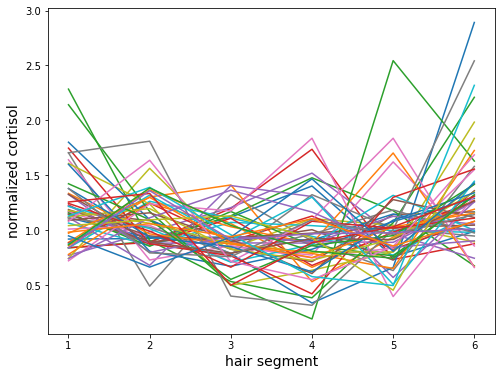

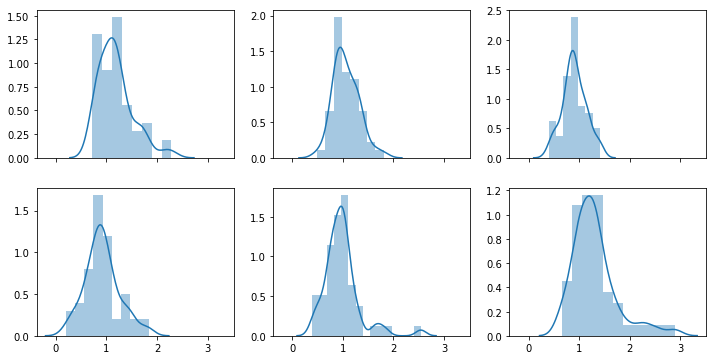

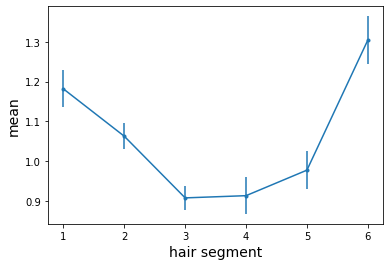

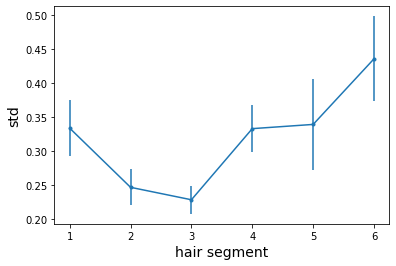

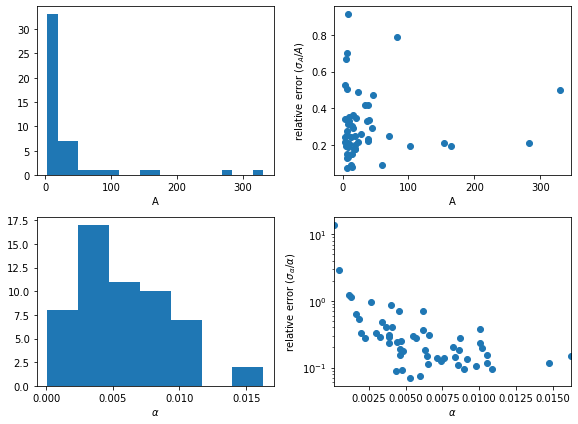

Mean personal decaying constant = 0.006
STD of personal decaying constants = 0.003
SEM = 0.00046


In [13]:
# Normalize by exponent
res_exp = full_analysis(low_mat, plot=True, exp=True, N_shuffles=1000)

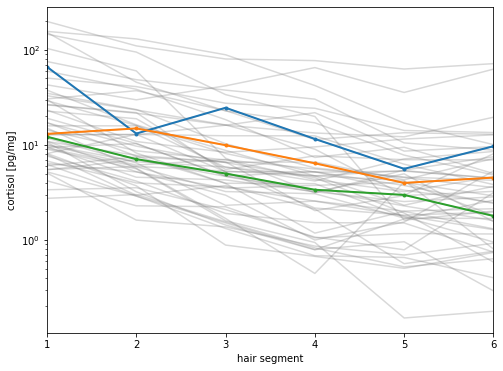

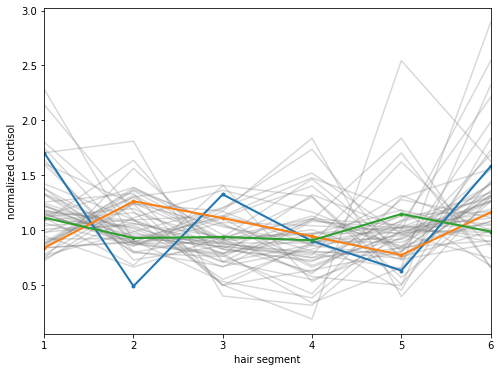

In [24]:
# Figure 2
participants_idx = [7, 9, 10]

plt.figure(figsize=(4*2, 3*2))
plt.plot(np.arange(1, 7), low_mat, c='gray', alpha=0.3)
plt.plot(np.arange(1, 7), low_mat[:, participants_idx], '.-', lw=2)
plt.yscale('log')
plt.xlabel('hair segment')
plt.ylabel('cortisol [pg/mg]')
plt.margins(x=0)

plt.figure(figsize=(4*2, 3*2))
plt.plot(np.arange(1, 7), res_exp['normalized'], c='gray', alpha=0.3)
plt.plot(np.arange(1, 7), res_exp['normalized'][:, participants_idx], '.-', lw=2)
plt.xlabel('hair segment')
plt.ylabel('normalized cortisol')
plt.margins(x=0)

In [16]:
# Calculating coefficient of variation of the fluctuations
participant_means = np.mean(res_exp['normalized'], axis=0)
participant_stds = np.std(res_exp['normalized'], axis=0)
participant_cvs = participant_stds / participant_means
print(np.mean(participant_cvs))
print(np.sqrt(np.mean(participant_cvs)**2-0.14**2))

0.2787821460199423
0.24107983105080444


A_slow / A_fast = 1.451, SE=0.167


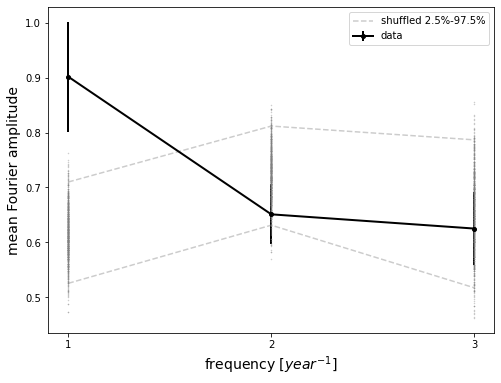

In [17]:
# Figure 3
plot_data_fft(res_exp)

weighted p value = 0.0032463593209561825
Cohen's D = 3.847283095074924
non parametric 2/1000 (p=0.002)
cliff delta = (0.99622, 'large')


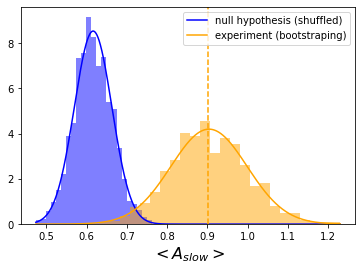

In [19]:
calculate_slow_freq_stats(res_exp)

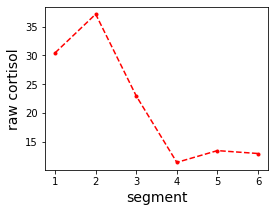

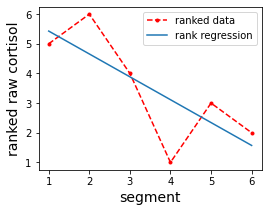

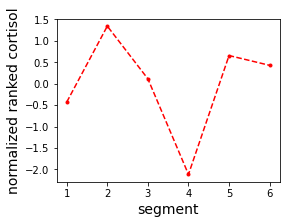

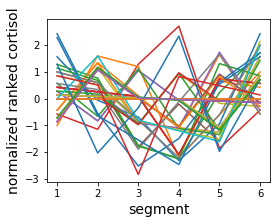

In [21]:
# Normalize by ranks
res_rank = full_analysis(low_mat, norm='rank', plot=True, N_shuffles=1000)

A_slow / A_fast = 1.293, SE=0.189


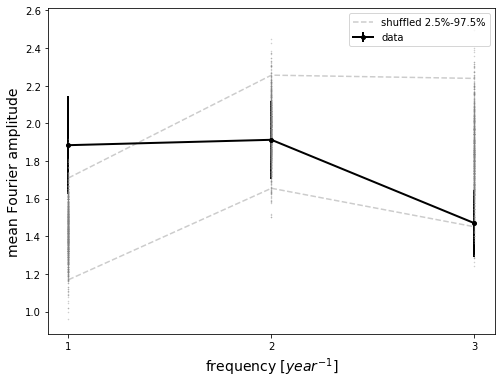

In [25]:
# Figure S2
plot_data_fft(res_rank)
plt.savefig('../../../results/figs/fig s2.pdf', transparent=True, dpi=500)

weighted p value = 0.05597677075461338
Cohen's D = 2.246730714113782
non parametric 49/1000 (p=0.049)
cliff delta = (0.897966, 'large')


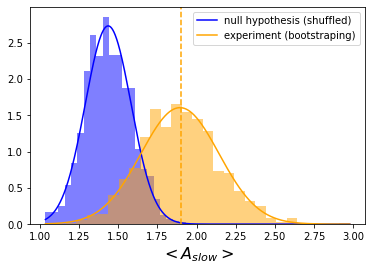

In [22]:
calculate_slow_freq_stats(res_rank)

### Analyzing the seasoned corrected data

In [23]:
with open('../data/seasoned_corrected.pkl', 'rb') as f:
    seasoned_corrected = pickle.load(f)

In [24]:
print(seasoned_corrected.shape)
seasoned_corrected

(59, 15)


sample ID           A     alpha season_factor                      \
segment                                             0         1         2   
0              10  102.268240  0.007403      0.877021  1.011088  1.134400   
1              11   38.400995  0.003828      0.877021  1.011088  1.134400   
2              15   27.893629  0.010515      0.869922  0.997960  1.127977   
3              20   15.953936  0.001138      0.849867  0.932180  1.078038   
4              21   18.558168  0.003890      0.849696  0.929844  1.075780   
5              22    5.756932  0.008544      0.849867  0.932180  1.078038   
6              24    7.047763  0.009181      0.889500  0.855453  0.961605   
7              25   46.681132  0.006156      0.895003  0.853450  0.954039   
8              26   12.551127  0.004643      0.942391  0.851221  0.903685   
9              27   17.877432  0.004613      0.942391  0.851221  0.903685   
10             28   13.082416  0.005991      0.992529  0.866804  0.871264   
11             29    7.786029  0.003379      0.992529  0.866804  0.871264   
12             30    5.344822  0.004557      1.027702  0.884301  0.857852   
13             31    7.187342  0.004633      1.027702  0.884301  0.857852   
14             32    9.108708  0.008223      1.150470  1.081497  0.930087   
15             34    9.656147  0.001826      1.043452  0.895003  0.853450   
16             35    3.635540  0.005477      1.043452  0.895003  0.853450   
17             36   19.528413  0.008992      1.043452  0.895003  0.853450   
18             37    6.557567  0.008691      1.043452  0.895003  0.853450   
19             38    7.424437  0.005255      1.048455  0.898966  0.852337   
20             39    6.815340  0.003962      1.050936  0.900997  0.851848   
21             40    7.818811  0.003656      1.063088  0.911624  0.850083   
22             41    9.381694  0.002970      1.063088  0.911624  0.850083   
23             42    3.895867  0.004389      1.067820  0.916082  0.849696   
24             43    8.012001  0.001926      1.079276  0.927691  0.849530   
25             45   14.300547  0.004348      1.079276  0.930087  0.849635   
26             46   39.697374  0.010558      1.077030  0.925319  0.849472   
27             47    6.170492  0.002200      1.079276  0.927691  0.849530   
28             48   23.471447  0.001619      1.079276  0.930087  0.849635   
29             49    7.773696  0.007094      1.079276  0.930087  0.849635   
30             50   15.075500  0.001277      1.079276  0.930087  0.849635   
31             51   36.532601  0.008620      1.081497  0.930087  0.849785   
32             52    1.263784  0.000100      1.081497  0.930087  0.849785   
33             53    8.440970  0.006149      1.106033  0.960382  0.855129   
34             54    2.018169  0.008232      1.129341  1.132644  1.006115   
35             57   23.132901  0.010041      1.107882  0.963010  0.855865   
36             58    8.110759  0.003871      1.109698  0.965651  0.856646   
37             59   70.364071  0.008347      1.111480  0.968303  0.857469   
38             60  330.363999  0.016273      1.122979  0.987106  0.864437   
39             62   82.104041  0.010078      1.136188  1.014249  0.876347   
40             63   39.131984  0.007632      1.140331  1.025026  0.882638   
41             64   16.030115  0.014753      1.140331  1.025026  0.882638   
42             65    2.998247  0.013616      1.140331  1.025026  0.882638   
43             66    7.384922  0.000453      1.147663  1.050936  0.900997   
44             67   18.846153  0.004804      1.150133  1.067820  0.916082   
45             68    9.839346  0.005690      1.136685  1.124475  0.989816   
46             69   16.086863  0.030891      1.136685  1.124475  0.989816   
47             70   18.593404  0.006425      1.134400  1.127354  0.995245   
48             71  282.630596  0.009794      1.130666  1.131381  1.003398   
49             72  165.202883  0.003251      1.129341  1.132644  1.006115   
50  

In [25]:
excluded = set(low_df['subject ID'][valid_subjects_idx].values.astype(str)) ^ set(seasoned_corrected['sample ID'].values)
for s in excluded:
    seasoned_corrected.drop(index=seasoned_corrected.index[seasoned_corrected['sample ID'] == s], inplace=True)

In [26]:
seasoned_corrected_mat = seasoned_corrected['value_season_corrected'].to_numpy().T
seasoned_factors = seasoned_corrected['season_factor'].to_numpy().T

In [27]:
seasoned_corrected_mat.shape, seasoned_factors.shape

((6, 55), (6, 55))

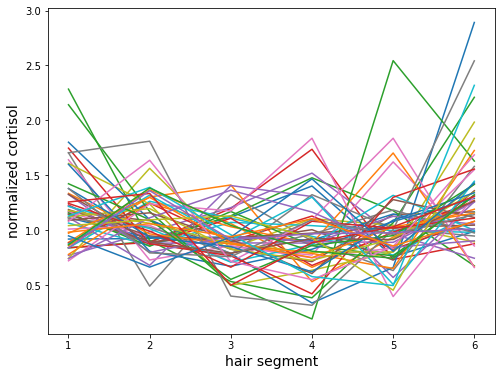

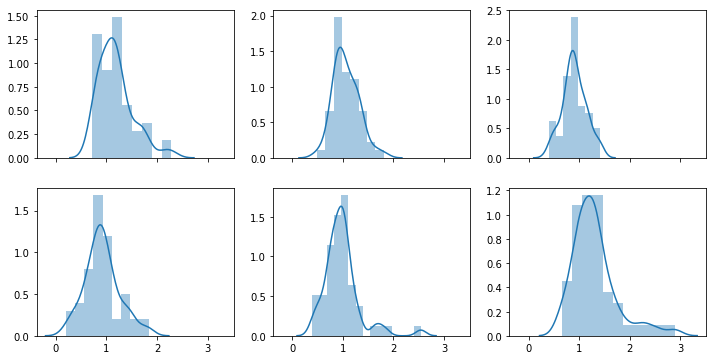

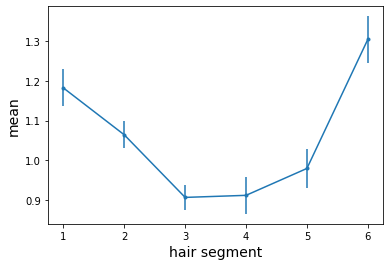

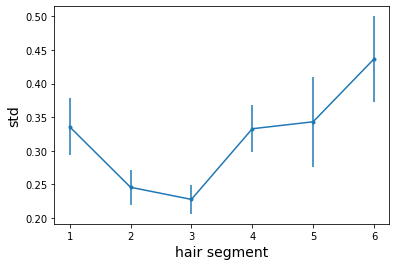

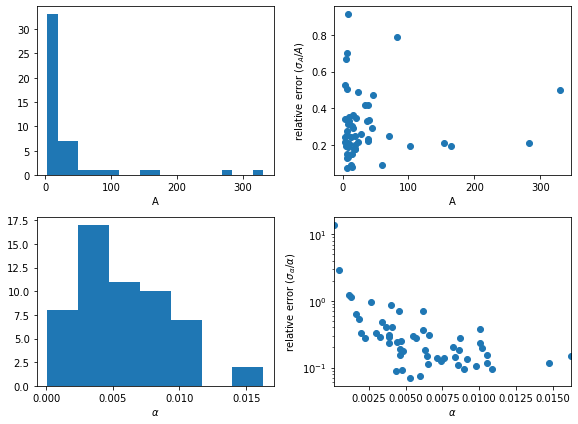

Mean personal decaying constant = 0.006
STD of personal decaying constants = 0.003
SEM = 0.00046


In [28]:
season_corrected_res = full_analysis(low_mat, plot=True, exp=True, N_shuffles=1000, seasons=seasoned_factors)

In [29]:
participant_means = np.mean(seasoned_corrected_mat, axis=0)
participant_stds = np.std(seasoned_corrected_mat, axis=0)
participant_cvs = participant_stds / participant_means
print(np.mean(participant_cvs))
print(np.sqrt(np.mean(participant_cvs)**2-0.14**2))

0.2648108883732888
0.2247772377289356


A_slow / A_fast = 1.330, SE=0.136


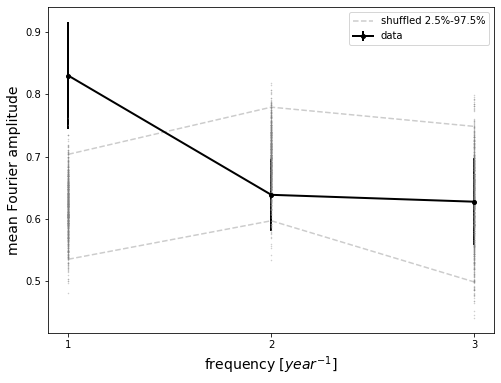

In [22]:
# Figure S1
plot_data_fft(season_corrected_res)
plt.savefig('../../../results/figs/fig s1 - seasonality corrected.pdf', transparent=True, dpi=500)

weighted p value = 0.01550081521971236
Cohen's D = 3.0490062292458275
non parametric 15/1000 (p=0.015)
cliff delta = (0.972672, 'large')


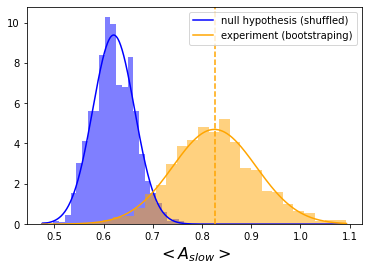

In [30]:
calculate_slow_freq_stats(season_corrected_res)